# Images classification

Used Amazon server with GPU.

## Import libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pygpu
import glob
import time
import os

from sklearn.model_selection import train_test_split
from scipy import misc

%matplotlib inline

## Import images

In [2]:
def read_data(root, folder_names):
    X = []
    y = []
    for i, folder in enumerate(folder_names):
        for image_path in glob.glob(os.path.join(root, folder) + '*.png'):
            X.append(misc.imread(image_path).astype(np.float32))
            target = np.zeros(len(folder_names)).astype(int)
            target[i] = 1
            y.append(target)
    X = np.asarray(X)
    y = np.asarray(y)
    return X, y

In [3]:
root = 'clocks&crocs/'
folder_names = ['clocks/', 'crocodiles/']
X, y = read_data(root, folder_names)

In [4]:
y[0]

array([1, 0])

In [5]:
X.shape

(1000, 32, 32, 3)

## Print some images

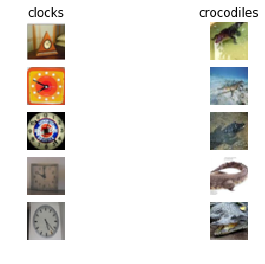

In [6]:
classes = ['clocks', 'crocodiles']
num_classes = len(classes)
samples_per_class = 5
for y_cls, cls in enumerate(classes):
    idxs = np.flatnonzero(np.array([x[1] for x in y]) == y_cls)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y_cls + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].astype('uint8'))#.transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Split sample into train and test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 32, 32, 3) (200, 32, 32, 3) (800, 2) (200, 2)


# My model

I wanted to augmentate dataset, therefore I found library, which do this process easily.

In [9]:
from __future__ import division, print_function, absolute_import
import tflearn
from tflearn.data_utils import shuffle
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.normalization import batch_normalization
from tflearn.layers.estimator import regression

## Prepare images for neural network

https://datascience.stackexchange.com/questions/5224/how-to-prepare-images-for-neural-network

### Suffle the data

In [10]:
X_train, y_train = shuffle(X_train, y_train)

### Normalize data

In [11]:
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

### Data augmentation

In [12]:
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_blur(sigma_max=3.)
img_aug.add_random_rotation(max_angle=20.)

### Network model

Tflearn examples, lasagne recipes and ML lessons at MIPT are main sources of my inspiration.

https://github.com/tflearn/tflearn/tree/master/examples

https://github.com/Lasagne/Recipes/blob/master/papers/deep_residual_learning/Deep_Residual_Learning_CIFAR-10.py

https://github.com/ml-mipt/ml-mipt-part1

In [13]:
net = input_data(shape=[None, 32, 32, 3],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug)

net = conv_2d(net, 64, 5, activation='leaky_relu')
net = batch_normalization(net)
net = conv_2d(net, 64, 3, activation='leaky_relu')
net = batch_normalization(net)
net = max_pool_2d(net, 2)
net = dropout(net, 0.5)

net = conv_2d(net, 32, 3, activation='leaky_relu')
net = batch_normalization(net)
net = conv_2d(net, 64, 3, activation='leaky_relu')
net = batch_normalization(net)
net = max_pool_2d(net, 2)

net = fully_connected(net, 256, activation='leaky_relu')
net = dropout(net, 0.5)

net = fully_connected(net, 2, activation='softmax')

net = regression(net, optimizer='adam', loss='categorical_crossentropy', learning_rate=0.001)

model = tflearn.DNN(net, tensorboard_verbose=0)

### Train that model

In [14]:
model.fit(X_train, y_train, n_epoch=150, shuffle=True, validation_set=(X_test, y_test),
          show_metric=True, batch_size=100, snapshot_epoch=True, run_id='images-classifier')

# Save model to a file
model.save("images-classifier.tfl")
print("Network trained and saved")

Training Step: 1199  | total loss: 0.11058 | time: 7.759s
| Adam | epoch: 150 | loss: 0.11058 - acc: 0.9778 -- iter: 700/800
Training Step: 1200  | total loss: 0.10721 | time: 9.869s
| Adam | epoch: 150 | loss: 0.10721 - acc: 0.9790 | val_loss: 0.19629 - val_acc: 0.9400 -- iter: 800/800
--
INFO:tensorflow:/home/ec2-user/code/images-classifier.tfl is not in all_model_checkpoint_paths. Manually adding it.
Network trained and saved


Dataset is small, therefore accuracy fluctuate from 93% to 95%.